In [1]:
import json
import os
import requests
import io
import PIL
import PIL.Image as PImage
from PIL import ImageEnhance
import math
from pprint import pprint
import glob
from collections import Counter
from datetime import datetime
import shutil
import numpy as np
import math

In [2]:
#大数据平台地址，无需修改
API_BASE_URL = 'http://fireeye-test-backend-container:9090/api/'  
#tf modelserver的地址，无需修改
TF_SERVING_BASE_URL = 'http://fireeye-test-model-container:8501/' 
# 根据云平台中的视觉任务实际的编号进行设置
task_id='1ac1e8a095df4611af387d9934799251'  
# 注意，/workspace为工作目录的根目录k
image_dir = './image'  
# 根据大数据平台web中的任务管理显示情况设定
id_code_mapping = {  
    'dbee3deebc5444f5b011da4e5518752c': '0',
    'edb4cb51d54644c08aa122d3f041bb0a': '1'
}
# 图片高度，单位为像素
img_height = 218  
# 图片宽度，单位为像素
img_width = 175 

In [3]:
num_images = requests.get(
    url=API_BASE_URL+'image/count', 
    params=dict(
        task_id=task_id,
        has_truth=True
    )
).json()

print('该任务类别下的图片数量：',num_images)

该任务类别下的图片数量： 316


In [4]:
import pprint

def get_image_records(task_id):
    resp = requests.get(
        url=API_BASE_URL+'image', 
        params=dict(
            task_id=task_id,
            has_truth=True            
        )
    )
    
    if resp.status_code == 200:
        return resp.json()
    else:
        raise RuntimeError(resp.text)
    
image_records=get_image_records(task_id)
print(len(image_records))
pprint.pprint(image_records[:2])

316
[{'id': '77416b6b03fa41a2bf562569672ed42d',
  'platform_id': '7f0d3278fa7b47968a085618bb1513b8',
  'slot': '1',
  'task_id': '1ac1e8a095df4611af387d9934799251',
  'time': 1693189382.067,
  'truth_id': 'dbee3deebc5444f5b011da4e5518752c'},
 {'id': '2f4fc75eb1e942f4a5e22ec99df91517',
  'platform_id': '7f0d3278fa7b47968a085618bb1513b8',
  'slot': '1',
  'task_id': '1ac1e8a095df4611af387d9934799251',
  'time': 1693189382.045,
  'truth_id': 'dbee3deebc5444f5b011da4e5518752c'}]


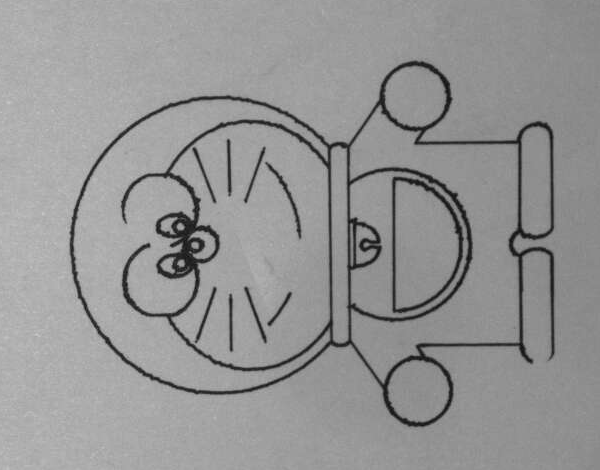

In [5]:
def get_image_by_id(id):
    r = requests.get(url=API_BASE_URL+'image/'+id)
    if r.status_code == 200:
        return PIL.Image.open(io.BytesIO(r.content))
    else:
        raise RuntimeError(r.text)
img = get_image_by_id(image_records[0]['id']) 
img.show()

In [6]:
import numpy as np
import math

task_dir = os.path.join(image_dir, task_id)
train_dir = os.path.join(task_dir, 'train')
dev_dir = os.path.join(task_dir, 'dev')
test_dir = os.path.join(task_dir, 'test')

id_code_mapping = {  # 根据web界面显示情况设定
    'dbee3deebc5444f5b011da4e5518752c': '0',
    'edb4cb51d54644c08aa122d3f041bb0a': '1'
}
np.random.seed(123)
for record in image_records:
    if record['truth_id'] is None:
        continue
    if np.random.uniform(0, 1) < 0.6:  # 需要通过修改数值来控制测试集的比例
        dst_dir = os.path.join(train_dir, id_code_mapping[str(record['truth_id'])])
    elif np.random.uniform(0, 1) < 0.5: 
        dst_dir = os.path.join(dev_dir, id_code_mapping[str(record['truth_id'])])
    else:
        dst_dir = os.path.join(test_dir, id_code_mapping[str(record['truth_id'])])
    if not os.path.exists(dst_dir):
        os.makedirs(dst_dir)
    image_id = record['id']
    dst = os.path.join(dst_dir, image_id +'.png')
    resp = requests.get(API_BASE_URL + f'image/{image_id}')
    if resp.status_code != 200:
        raise ValueError('Failed to get image: '+str(resp))
    in_stream = io.BytesIO(resp.content)
    pimage = PImage.open(in_stream)
    pimage.save(dst)

In [7]:
import pathlib

train_image_count = len(list(pathlib.Path(train_dir).glob('*/*.png')))
dev_image_count = len(list(pathlib.Path(dev_dir).glob('*/*.png')))
test_image_count = len(list(pathlib.Path(test_dir).glob('*/*.png')))
print(train_image_count, dev_image_count, test_image_count)

236 102 81


In [8]:
import tensorflow as tf
from tensorflow.keras import layers

print(tf.__version__)

2.8.2


In [9]:
batch_size = 16 # 每一批所处理的图片数量,可以根据需要进行更改

In [10]:
def build_dataset(data_dir, target=None):
    all_images = []
    all_labels = []
    for i in range(4):
        if target is not None and i != target:
            continue
        images = glob.glob(os.path.join(data_dir, f'{i}/*.png'), recursive=True)
        all_images.extend(images)
        all_labels.extend([i] * len(images))
    ds = tf.data.Dataset.from_tensor_slices((all_images, all_labels))
    ds = ds.map(lambda x,y: (tf.io.encode_base64(tf.io.read_file(x)) ,y))
    ds = ds.shuffle(100, seed=123)
    ds = ds.batch(batch_size)
    return ds


train_ds = build_dataset(train_dir)
dev_ds = build_dataset(dev_dir)
test_ds = build_dataset(test_dir)

2023-09-01 08:34:11.691391: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-09-01 08:34:11.691426: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-09-01 08:34:11.691449: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (58c881efe57c): /proc/driver/nvidia/version does not exist
2023-09-01 08:34:11.691665: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
print(train_ds)
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

<BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
(16,)
(16,)


In [12]:
#from keras import models
#

#def process_base64_image(s):
#    img = tf.io.decode_base64(s)
#    img = tf.io.decode_png(img, channels=3)
#    img = tf.image.resize(img, (img_height, img_width), antialias=True)    
#    return img

#model = models.Sequential([
 #   layers.Lambda(
 #           (
#                lambda x: tf.map_fn(
#                    process_base64_image,
#                    x,
#                    fn_output_signature=tf.TensorSpec(shape=(int(img_height), int(img_width), 3), dtype=tf.float32))
#            ),
#            name='decode_base64_png'
#        ),
#    tf.keras.layers.Conv2D(32, (3, 3),  activation='relu', input_shape=(150, 150, 3)),
#    tf.keras.layers.MaxPool2D(2, 2),
#    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
#    tf.keras.layers.MaxPooling2D(2, 2),
#    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
#    tf.keras.layers.MaxPooling2D(2, 2),
#    tf.keras.layers.Flatten(),
#    tf.keras.layers.Dense(512, activation='relu'),
#    tf.keras.layers.Dense(1, activation='sigmoid')])

#from keras import optimizers
#model.compile(
#    loss='binary_crossentropy',
#    optimizer=optimizers.RMSprop(lr=1e-4),
#    metrics=['accuracy'])
#model.summary()
#model.compile(
#  optimizer='adam',
#  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
#  metrics=['accuracy'])


In [13]:
def process_base64_image(s):
    img = tf.io.decode_base64(s)
    img = tf.io.decode_png(img, channels=3)
    img = tf.image.resize(img, (img_height, img_width), antialias=True)    
    return img

# 构建模型
model = tf.keras.Sequential([
    layers.Lambda(
            (
                lambda x: tf.map_fn(
                    process_base64_image,
                    x,
                    fn_output_signature=tf.TensorSpec(shape=(int(img_height), int(img_width), 3), dtype=tf.float32))
            ),
            name='decode_base64_png'
        ),
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(img_height, img_width, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(img_height, img_width, 3)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2)
])

In [14]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [15]:
#from keras.preprocessing.image import ImageDataGenerator

#train_ds = ImageDataGenerator(rescale=1./255)
#test_ds = ImageDataGenerator(rescale=1./255)

#terain_generator = train_ds.flow_from_directory(
#      train_dir,
#    target_size = (150, 150),
#    batch_size = 20,
#    class_mode = 'binary')
#validation_generator = test_ds.flow_from_directory(
#test_ds,
#target_size=(150,150),
#batch_size = 20,
#class_mode = 'binary')

In [16]:
epochs = 20
history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=dev_ds
)

Epoch 1/20
15/15 [==============================] - 6s 376ms/step - loss: 461.7383 - accuracy: 0.6186 - val_loss: 48.8895 - val_accuracy: 0.7745
Epoch 2/20
15/15 [==============================] - 6s 371ms/step - loss: 24.5597 - accuracy: 0.6144 - val_loss: 4.0911 - val_accuracy: 0.7745
Epoch 3/20
15/15 [==============================] - 6s 370ms/step - loss: 3.3095 - accuracy: 0.6144 - val_loss: 0.8587 - val_accuracy: 0.7745
Epoch 4/20
15/15 [==============================] - 6s 374ms/step - loss: 0.5397 - accuracy: 0.7627 - val_loss: 0.3294 - val_accuracy: 0.7843
Epoch 5/20
15/15 [==============================] - 6s 371ms/step - loss: 0.3028 - accuracy: 0.8856 - val_loss: 0.2948 - val_accuracy: 0.8529
Epoch 6/20
15/15 [==============================] - 6s 374ms/step - loss: 0.2632 - accuracy: 0.9025 - val_loss: 0.2406 - val_accuracy: 0.8922
Epoch 7/20
15/15 [==============================] - 6s 372ms/step - loss: 0.1609 - accuracy: 0.9619 - val_loss: 0.2501 - val_accuracy: 0.8627
Ep

In [17]:
model.evaluate(test_ds)

6/6 [==============================] - 1s 93ms/step - loss: 0.0841 - accuracy: 0.9753


[0.0841139554977417, 0.9753086566925049]

In [18]:
import pytz
from datetime import datetime

model_version =  datetime.now(pytz.timezone('Asia/Shanghai')).strftime('%Y%m%d%H%M%S')
tf.keras.models.save_model(
    model,
    f'/models/slot1/{model_version}/',
    overwrite=True,
)

2023-09-01 08:36:10.014554: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /models/slot1/20230901163609/assets


In [20]:
import base64

def predict_image(images):    
    bimages = []
    for image in images:
        with open(image, 'rb') as  fimage:
            content = fimage.read()
        bimage = base64.urlsafe_b64encode(content).decode()
        bimages.append(bimage)
    req_data ={
      'inputs': bimages,
    } 
    response = requests.post(TF_SERVING_BASE_URL+f'v1/models/slot1/versions/{model_version}:predict', # 根据部署地址填写
                             json=req_data,
                             headers={"content-type": "application/json"})
    if response.status_code != 200:
        raise RuntimeError('Request tf-serving failed: ' + response.text)
    resp_data = json.loads(response.text)    
    if 'outputs' not in resp_data \
                        or type(resp_data['outputs']) is not list:
        raise ValueError('Malformed tf-serving response')
    outputs = np.argmax(resp_data['outputs'], axis=1).tolist()
    return outputs


def test_image_model(test_dir, code, batch_size=10):    
    images = list(pathlib.Path(test_dir).joinpath(str(code)).glob('./*.png')) 
    codes = []
    for step in range(math.ceil(len(images)/batch_size)):
        outputs = predict_image(images[step*batch_size:(step+1)*batch_size])
        for i, o in zip(images, outputs):            
            if o != code:
                print('错误图片：', i)
        codes.extend(outputs)
    accuracy = round(codes.count(code) / len(codes), 4)
    return accuracy, codes

accuracy, codes = test_image_model(test_dir, 0)
print('类别0的准确率', accuracy)
print('类别0的测试结果', codes)
accuracy, codes = test_image_model(test_dir, 1)
print('类别1的准确率', accuracy)
print('类别1的测试结果', codes)

错误图片： image/1ac1e8a095df4611af387d9934799251/test/0/c39a983cd0ad47f9b14a819b45449c34.png
类别0的准确率 0.9565
类别0的测试结果 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
错误图片： image/1ac1e8a095df4611af387d9934799251/test/1/30044366-fb05-42ad-9019-b83e0b75b981.png
类别1的准确率 0.9828
类别1的测试结果 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]
